# library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf

/home/mdnurualabsarsiddiky/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# pip install numpy==1.21

In [2]:
import splitfolders
import random
import shutil
import scipy
import torch
from numpy import size
import seaborn as sns
from pathlib import Path
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Convolution2D, MaxPool2D, Flatten
from keras.models import Model
from keras.layers import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import compute_class_weight
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime
from keras.utils import plot_model

In [ ]:
# pip install split-folders

# code

In [30]:
## access dataset
main_dataset = Path ('/home/mdnurualabsarsiddiky/Desktop/ECGR8119/HW1/') 
    
data_path = Path('/home/mdnurualabsarsiddiky/Desktop/ECGR8119/HW1/train') ## data directory containing 25000 images

# data splitting (subdirectory present)

In [6]:
input_folder = data_path
output_folder = Path ('/home/mdnurualabsarsiddiky/Desktop/ECGR8119/HW1/splitdata')
splitfolders.ratio (input_folder, output_folder, seed =1337, ratio = (.7,.2,.1))

Copying files: 25000 files [00:08, 3121.40 files/s]


# check gpu (torchCUDA compatible)

In [3]:
import torch
print(torch.cuda.is_available())

True


# initiating data generator

In [4]:
train_dir = Path ('/home/mdnurualabsarsiddiky/Desktop/ECGR8119/HW1/splitdata/train')# has 2 folders: cat, dog
val_dir   = Path ('/home/mdnurualabsarsiddiky/Desktop/ECGR8119/HW1/splitdata/val')#has 2 folders: cat, dog
test_dir = Path ('/home/mdnurualabsarsiddiky/Desktop/ECGR8119/HW1/splitdata/test')# same

#create a data generator from ImageDataGenerator which performs augmentation
#rescaling /255 to get pixel values between 0 and 1
#horizontal and vertical flip set to true
#rotation range set to 30 degrees
train_data_gen = ImageDataGenerator(
    
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 30,
    fill_mode = 'constant' )


#data generator to augment validation and test images. only rescaling is applied
val_test_data_gen = ImageDataGenerator(
    
    rescale = 1./255,
)

# test_data_generator= ImageDataGenerator(  
#     rescale = 1./255)


#create a training, validation and testing generator which generates a batch of images from the  data
#shuffle set to true to add variance only for training and validation set

train_gen = train_data_gen.flow_from_directory(
    directory= train_dir,
#     target_size = (128, 128),
    class_mode = 'categorical',
    color_mode = 'rgb',
#     batch_size = 50,
#      batch_size = 10,
      batch_size = 10,
    shuffle = True)
#grab the number of samples
train_num = train_gen.samples


validate_gen = val_test_data_gen.flow_from_directory(
    directory= val_dir,
#     target_size = (128, 128),
    class_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = 10,
#     batch_size = 50,
    shuffle = True)
#grab number of samples
validate_num = validate_gen.samples


test_gen = val_test_data_gen.flow_from_directory(
    directory= test_dir,
#     target_size = (128, 128),
    class_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = 10,
#     batch_size = 50,
    shuffle = False)
#grab the number of samples
test_num = test_gen.samples




Found 17500 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# Custom ImageLoader (alt. to ImageDataGenerator)

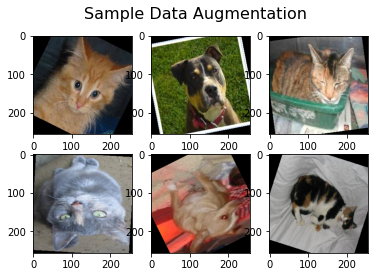

y Labels:  [[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [5]:
#visualize the augmented data
# Get the next batch of images from the train generator
train_images, train_labels = train_gen.next()

#grab the first 8 in the batch and their labels and plot them
for k in range(1,7):
    sample_img = train_images[k,:,:,:]
    plt.subplot(2, 3, k)
    plt.imshow(sample_img)
plt.suptitle('Sample Data Augmentation', fontsize = 16)    
plt.show()

print('y Labels: ', train_labels[1:7])

In [6]:
# #train_images[0].shape

x = train_images[0].shape
# print (x)
# image_input = Input(x)
# image_input.shape


# initiating the model

In [7]:
# loading the resnet50 model for pretrained initialization
# weights set to imagenet

image_input = Input (x)
base_model = tf.keras.applications.resnet50.ResNet50(input_tensor = image_input,weights = 'imagenet', include_top=False)

#Freeze ResNet's layers so their paramteres dont get retrained
# for layer in base_model.layers[:-6]:
#     layer.trainable = False
base_output = base_model.layers[-1].output
flat1 = Flatten()(base_output)

fc1 = Dense(500, activation = 'relu')(flat1)
dropfc1 = Dropout(0.5)(fc1)
fc2 = Dense(100, activation = 'relu')(dropfc1)
dropfc2 = Dropout(0.5)(fc2)

predictions = Dense(2, activation = 'sigmoid')(dropfc2)


#creating new model
model = Model (inputs = base_model.input, outputs = predictions)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 64, 64, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 32, 32, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 32, 32, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 32, 32, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 16, 16, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 16, 16, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 16, 16, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

# hyperparameters and checkpoints

In [8]:
from tensorflow.python.keras.utils.np_utils import to_categorical

opt = Adam (learning_rate = 1e-4 )
model.compile(optimizer= opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

#early stopping to break training loop
# early_stop = EarlyStopping(monitor='val_loss', patience=3)

#checkpoints
# checkpoint = ModelCheckpoint('best_model.h5',
#                              monitor='val_loss',
#                              save_best_only=True,
#                              mode='min')


fold_num=1

# Folder setup
init_time = datetime.now()
current_time = init_time.strftime('%Y%m%d_%H%M%S')
name_dir = 'trained_models_' + current_time + '_fold_num' + str(fold_num)
os.mkdir(name_dir)

# Callbacks1: ModelCheckpointer
model_file_format = name_dir + '/model_' + str(fold_num) + '_model.{epoch:04d}.hdf5'
checkpoint = ModelCheckpoint(model_file_format, monitor ='val_loss', save_best_only = True, verbose = 1)

# Callbacks2: TensorBoard
tensor_check = './logs/' + current_time + '_train_testsplit' + str(fold_num)
tensor_board = TensorBoard(tensor_check)

# Callbacks3: EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='auto')
# Plot model
figure_name = name_dir + '/model_output.png'
plot_model(model, figure_name, show_shapes = True)
#plt.show (model, figure_name, show_shapes = True)


# Display model


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 64, 64, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 32, 32, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 32, 32, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 32, 32, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 16, 16, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 16, 16, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 16, 16, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

# training

In [9]:
history = model.fit(
    train_gen,
    epochs = 10,
    steps_per_epoch = train_num // 50,
    validation_data = validate_gen,
    validation_steps = validate_num // 50,
    callbacks=[early_stop, tensor_board],
    verbose =1,)

early_stop_name = name_dir + '/fold_num_' + str(fold_num) + 'early_stop_model.hdf5'
model.save_weights(early_stop_name)

Epoch 1/10
350/350 [==============================] - 37s 89ms/step - loss: 0.6503 - accuracy: 0.8637 - val_loss: 2.3379 - val_accuracy: 0.4770
Epoch 2/10
350/350 [==============================] - 30s 85ms/step - loss: 0.2149 - accuracy: 0.9266 - val_loss: 0.4293 - val_accuracy: 0.7610
Epoch 3/10
350/350 [==============================] - 30s 86ms/step - loss: 0.3025 - accuracy: 0.9091 - val_loss: 0.3693 - val_accuracy: 0.8840
Epoch 4/10
350/350 [==============================] - 30s 86ms/step - loss: 0.2269 - accuracy: 0.9334 - val_loss: 0.1967 - val_accuracy: 0.9410
Epoch 5/10
350/350 [==============================] - 30s 87ms/step - loss: 0.1737 - accuracy: 0.9369 - val_loss: 0.3439 - val_accuracy: 0.9160
Epoch 6/10
350/350 [==============================] - 30s 87ms/step - loss: 0.1793 - accuracy: 0.9386 - val_loss: 0.0998 - val_accuracy: 0.9600
Epoch 7/10
350/350 [==============================] - 30s 86ms/step - loss: 0.1723 - accuracy: 0.9483 - val_loss: 0.5501 - val_accuracy:

# testing

In [10]:
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen), verbose=1)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')



250/250 [==============================] - 6s 23ms/step - loss: 0.1489 - accuracy: 0.9540
Test Loss: 0.1489
Test Accuracy: 0.9540


# confusion matrix

In [11]:
test_labels = test_gen.classes
print (test_labels)
print (len(test_labels))
print (train_gen.classes)
print (validate_gen.classes)


[0 0 0 ... 1 1 1]
2500
[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]


250/250 [==============================] - 6s 21ms/step


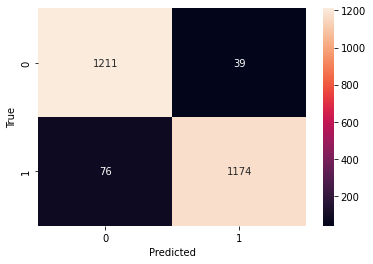

In [12]:
# Generate predictions on test data
test_predictions = model.predict(test_gen)
test_predictions = np.argmax(test_predictions, axis=1)
test_labels = test_gen.classes

# Plot the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# plotting

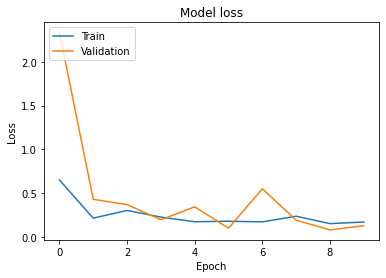

In [13]:
#plotting validation and training losses obtained from training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()